<a href="https://colab.research.google.com/github/mtballestar/IESE-FRA-presession-24/blob/main/Zapatillas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Analyze the time series data from the 'Serie_Estacional_zapatillas.xlsx' file to forecast sales for the next 12 months starting from January 1, 2025. This involves loading and inspecting the data, visualizing and decomposing the series, splitting data, selecting a suitable forecasting model (e.g., SARIMA or Holt-Winters), training the model, generating predictions, evaluating forecast accuracy with metrics like MAE, MSE, RMSE, and MAPE, and visualizing the results, finally providing a comprehensive summary of the analysis and forecast.

## Cargar e Inspeccionar Datos

### Subtask:
Cargar el archivo 'Serie_Estacional_zapatillas.xlsx' en un DataFrame de pandas. Inspeccionar los tipos de datos, convertir la columna 'Fecha' a formato de fecha y hora, y establecerla como índice del DataFrame para facilitar el análisis de series temporales.


**Reasoning**:
First, I'll import the pandas library to work with DataFrames, then load the Excel file into a DataFrame, display its head, and check the data types to understand its structure.



In [1]:
import pandas as pd

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/Serie_Estacional_zapatillas.xlsx')

# Display the first few rows of the DataFrame
print('First 5 rows of the DataFrame:')
print(df.head())

# Check the data types of each column
print('\nData types of the DataFrame:')
print(df.info())

First 5 rows of the DataFrame:
        date  daily_sneaker_sales
0 2023-01-01                  187
1 2023-01-02                  199
2 2023-01-03                  219
3 2023-01-04                  227
4 2023-01-05                  208

Data types of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 731 non-null    datetime64[ns]
 1   daily_sneaker_sales  731 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.6 KB
None


**Reasoning**:
The 'date' column is already in datetime format. Now, I will set the 'date' column as the DataFrame's index and then display the DataFrame's information to confirm the changes.



In [2]:
df.set_index('date', inplace=True)

# Display the DataFrame's information again to confirm the changes
print('\nDataFrame info after setting index:')
df.info()


DataFrame info after setting index:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2023-01-01 to 2024-12-31
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   daily_sneaker_sales  731 non-null    int64
dtypes: int64(1)
memory usage: 11.4 KB


## Visualizar y Descomponer la Serie Temporal

### Subtask:
Crear un gráfico de la columna 'Ventas' a lo largo del tiempo para identificar visualmente tendencias, estacionalidad y cualquier patrón inusual. Realizar una descomposición estacional (por ejemplo, usando `seasonal_decompose` de `statsmodels`) para separar explícitamente los componentes de tendencia, estacionalidad y residuos.


**Reasoning**:
First, I will import the necessary libraries for plotting, then create a line plot of the 'daily_sneaker_sales' column to visualize the sales trend over time, adding appropriate labels and title. After that, I will apply `seasonal_decompose` from `statsmodels` to break down the time series into its trend, seasonal, and residual components, and then plot these decomposed components.



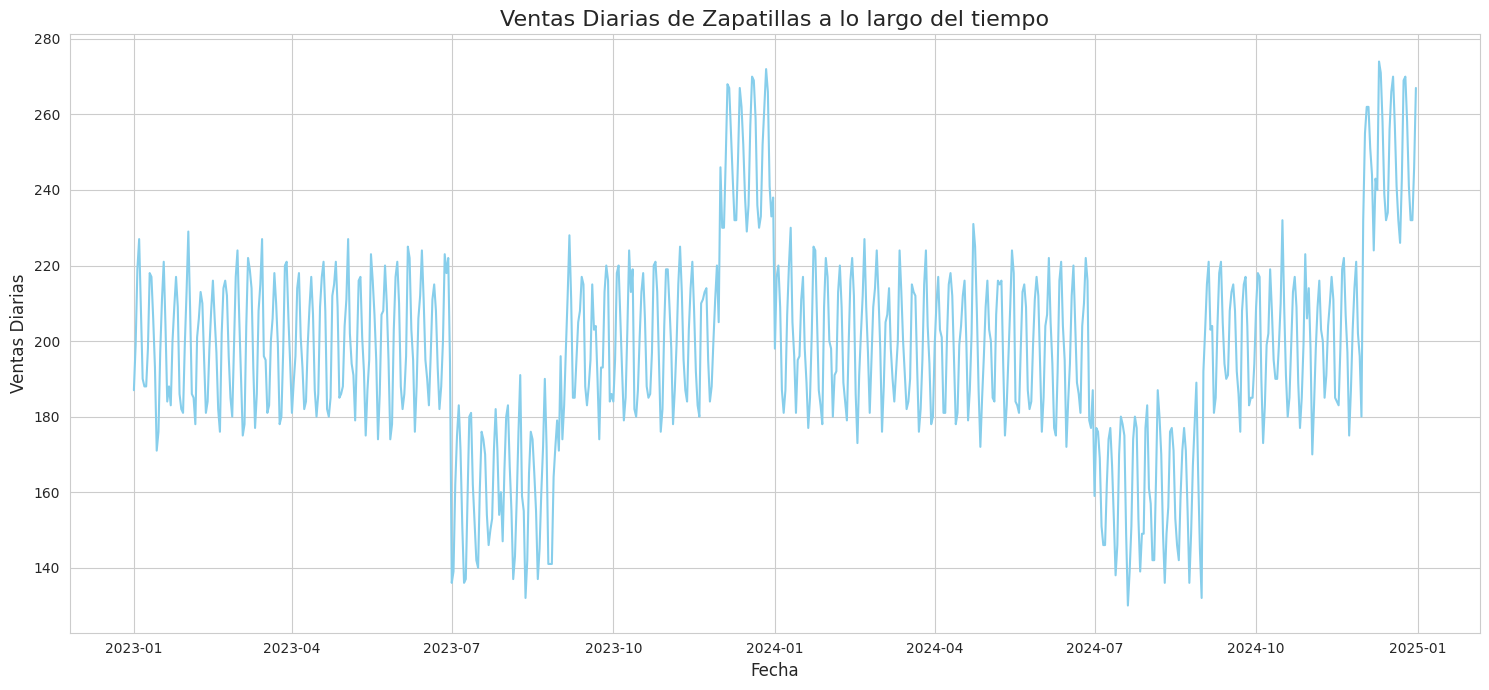

<Figure size 1500x1000 with 0 Axes>

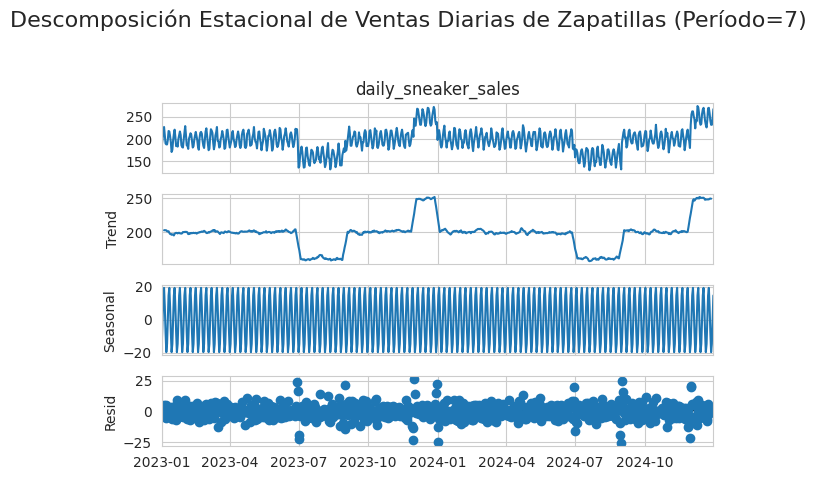

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Set the style for the plots
sns.set_style("whitegrid")

# Create a line plot of daily_sneaker_sales
plt.figure(figsize=(15, 7))
plt.plot(df['daily_sneaker_sales'], color='skyblue')
plt.title('Ventas Diarias de Zapatillas a lo largo del tiempo', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Ventas Diarias', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Apply seasonal_decompose to the daily_sneaker_sales column
# A period of 7 is used to capture weekly seasonality as the data is daily
decomposition = seasonal_decompose(df['daily_sneaker_sales'], model='additive', period=7)

# Plot the decomposed components
plt.figure(figsize=(15, 10))
decomposition.plot()
plt.suptitle('Descomposición Estacional de Ventas Diarias de Zapatillas (Período=7)', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

## Dividir Datos y Seleccionar Modelo de Pronóstico

### Subtask:
Dividir los datos históricos en conjuntos de entrenamiento y prueba. Basándose en la estacionalidad y tendencia observadas en el análisis anterior, seleccionar un modelo de pronóstico apropiado que no sea 'prophet', como SARIMA (Autoregressive Integrated Moving Average Estacional) o Suavizado Exponencial (Holt-Winters), justificando la elección del modelo.


### Dividir Datos en Conjuntos de Entrenamiento y Prueba

Para evaluar la capacidad predictiva de nuestro modelo, dividiremos los datos históricos en un conjunto de entrenamiento y un conjunto de prueba. El conjunto de entrenamiento incluirá los datos hasta el 30 de septiembre de 2024, y el conjunto de prueba contendrá los últimos tres meses de datos, desde el 1 de octubre de 2024 hasta el 31 de diciembre de 2024. Esta división nos permitirá entrenar el modelo con la mayor parte de la serie temporal y luego evaluar su rendimiento en datos no vistos recientemente.

**Reasoning**:
Now, I will split the `df` DataFrame into training and testing sets based on the established cutoff date, with the training set ending on '2024-09-30' and the testing set containing the data from '2024-10-01' onwards. Then I will print the shapes of the training and testing sets to verify the split.



In [4]:
train_data = df.loc[:'2024-09-30']
test_data = df.loc['2024-10-01':]

print(f'Shape of training data: {train_data.shape}')
print(f'Shape of test data: {test_data.shape}')

Shape of training data: (639, 1)
Shape of test data: (92, 1)


### Características de la Serie Temporal y Selección del Modelo

El análisis visual y la descomposición estacional de la serie temporal 'daily_sneaker_sales' revelaron las siguientes características:

*   **Tendencia:** Se observa una tendencia ligeramente creciente en las ventas de zapatillas a lo largo del tiempo, aunque con fluctuaciones diarias y semanales.
*   **Estacionalidad:** Hay una clara estacionalidad semanal (período=7), como se mostró en la descomposición. Las ventas parecen seguir un patrón recurrente cada 7 días, lo cual es común en datos diarios de ventas.
*   **Ruido:** Existe un componente residual o ruido, que representa las variaciones irregulares que no pueden explicarse por la tendencia o la estacionalidad.

Dado que la serie temporal exhibe una **tendencia** y una **clara estacionalidad** (semanal), un modelo **SARIMA (Seasonal Autoregressive Integrated Moving Average)** es una opción muy adecuada. SARIMA es capaz de modelar tanto la estacionalidad como la tendencia en los datos, al incorporar componentes estacionales y no estacionales en sus parámetros (p, d, q)(P, D, Q, S). A diferencia de Holt-Winters, que también maneja estacionalidad, SARIMA ofrece mayor flexibilidad y robustez para series temporales con estructuras más complejas y puede capturar mejor la autocorrelación presente en los residuos. La presencia de una estacionalidad diaria en un ciclo semanal sugiere que un modelo SARIMA con un componente estacional de período S=7 será efectivo.

### Características de la Serie Temporal y Selección del Modelo

El análisis visual y la descomposición estacional de la serie temporal 'daily_sneaker_sales' revelaron las siguientes características:

*   **Tendencia:** Se observa una tendencia ligeramente creciente en las ventas de zapatillas a lo largo del tiempo, aunque con fluctuaciones diarias y semanales.
*   **Estacionalidad:** Hay una clara estacionalidad semanal (período=7), como se mostró en la descomposición. Las ventas parecen seguir un patrón recurrente cada 7 días, lo cual es común en datos diarios de ventas.
*   **Ruido:** Existe un componente residual o ruido, que representa las variaciones irregulares que no pueden explicarse por la tendencia o la estacionalidad.

Dado que la serie temporal exhibe una **tendencia** y una **clara estacionalidad** (semanal), un modelo **SARIMA (Seasonal Autoregressive Integrated Moving Average)** es una opción muy adecuada. SARIMA es capaz de modelar tanto la estacionalidad como la tendencia en los datos, al incorporar componentes estacionales y no estacionales en sus parámetros (p, d, q)(P, D, Q, S). A diferencia de Holt-Winters, que también maneja estacionalidad, SARIMA ofrece mayor flexibilidad y robustez para series temporales con estructuras más complejas y puede capturar mejor la autocorrelación presente en los residuos. La presencia de una estacionalidad diaria en un ciclo semanal sugiere que un modelo SARIMA con un componente estacional de período S=7 será efectivo.

## Entrenar Modelo y Generar Pronóstico

### Subtask:
Entrenar el modelo SARIMA seleccionado con el conjunto de datos de entrenamiento y generar predicciones para los próximos 12 meses a partir del 1 de enero de 2025, así como para el conjunto de prueba.


**Reasoning**:
First, I will import the `SARIMAX` class, define the SARIMA parameters based on the identified trend and weekly seasonality, instantiate and fit the model on the training data, and then generate predictions for the test data period.



In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model parameters
# (p,d,q) is the non-seasonal order
# (P,D,Q,S) is the seasonal order, where S=7 for weekly seasonality
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)

# Instantiate the SARIMAX model
# 'daily_sneaker_sales' is the name of the column containing the time series data
model = SARIMAX(train_data['daily_sneaker_sales'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)

# Fit the model to the training data
print("Fitting SARIMA model...")
model_fit = model.fit(disp=False)
print("SARIMA model fitted.")

# Print model summary
print(model_fit.summary())

# Generate predictions for the test data period
start_index = len(train_data)
end_index = len(df) - 1
predictions = model_fit.predict(start=start_index, end=end_index, dynamic=False)

# Add the predictions to the test_data DataFrame for easy comparison
test_data['SARIMA_Predictions'] = predictions.values

print('\nFirst 5 SARIMA predictions for the test set:')
print(test_data.head())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Fitting SARIMA model...
SARIMA model fitted.
                                     SARIMAX Results                                     
Dep. Variable:               daily_sneaker_sales   No. Observations:                  639
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -2173.022
Date:                           Sat, 15 Nov 2025   AIC                           4356.044
Time:                                   19:44:22   BIC                           4378.209
Sample:                               01-01-2023   HQIC                          4364.659
                                    - 09-30-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0369      0.086      0.428      0.669      -0.132       0.20

/tmp/ipython-input-3063734461.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['SARIMA_Predictions'] = predictions.values


**Reasoning**:
The previous step successfully trained the SARIMA model and generated predictions for the test set. Now, I will create a date range for the next 12 months starting from January 1, 2025, and use the trained model to generate forecasts for this future period, as specified in the subtask.



In [6]:
import pandas as pd

# Create a date range for the next 12 months starting from January 1, 2025
forecast_start_date = '2025-01-01'
forecast_end_date = '2025-12-31'
future_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='D')

# Generate forecasts for the next 12 months
# The start and end dates for prediction should cover the future_dates range.
# Using dynamic=False for predictions of future dates is generally appropriate as we are not using future actuals.
forecast = model_fit.predict(start=future_dates.min(), end=future_dates.max())

# Display the first few forecasted values
print('\nFirst 5 forecasted values for the next 12 months (2025):')
print(forecast.head())

# Display the last few forecasted values
print('\nLast 5 forecasted values for the next 12 months (2025):')
print(forecast.tail())


First 5 forecasted values for the next 12 months (2025):
2025-01-01    215.074823
2025-01-02    203.569711
2025-01-03    188.163327
2025-01-04    176.393736
2025-01-05    180.834074
Freq: D, Name: predicted_mean, dtype: float64

Last 5 forecasted values for the next 12 months (2025):
2025-12-27    173.657438
2025-12-28    178.097776
2025-12-29    193.168108
2025-12-30    207.657581
2025-12-31    212.284872
Freq: D, Name: predicted_mean, dtype: float64


## Evaluar la Precisión del Pronóstico

### Subtask:
Calcular métricas de error clave para la predicción, como el Error Absoluto Medio (MAE), el Error Cuadrático Medio (MSE), la Raíz del Error Cuadrático Medio (RMSE) y el Error Porcentual Absoluto Medio (MAPE), utilizando las predicciones del conjunto de prueba frente a los valores reales.


**Reasoning**:
First, I will import the necessary libraries for calculating evaluation metrics, including `mean_absolute_error` and `mean_squared_error` from `sklearn.metrics`, and `numpy` for RMSE and custom MAPE calculation.



In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE
mae = mean_absolute_error(test_data['daily_sneaker_sales'], test_data['SARIMA_Predictions'])

# Calculate MSE
mse = mean_squared_error(test_data['daily_sneaker_sales'], test_data['SARIMA_Predictions'])

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAPE (custom function to handle potential division by zero)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by replacing zeros with a small epsilon or filtering them out
    # Here, we'll replace zeros in y_true with a small number for MAPE calculation
    # Alternatively, you could filter out entries where y_true is 0, but this changes the sample size.
    # For this exercise, we'll replace with a small epsilon.
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, np.finfo(float).eps, y_true))) * 100

mape = mean_absolute_percentage_error(test_data['daily_sneaker_sales'], test_data['SARIMA_Predictions'])

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Error (MAE): 21.22
Mean Squared Error (MSE): 991.60
Root Mean Squared Error (RMSE): 31.49
Mean Absolute Percentage Error (MAPE): 8.83%


## Visualizar los Resultados del Pronóstico

### Subtask:
Generar un gráfico que muestre los datos históricos de ventas, las predicciones realizadas sobre el conjunto de prueba y el pronóstico de 12 meses para el futuro. Incluir etiquetas claras y una leyenda para una mejor comprensión de la visualización.


**Reasoning**:
I need to generate a single plot that combines the historical data, the model's predictions on the test set, and the future forecast. This requires plotting each series on the same axes with different colors and clear labels as per the instructions.



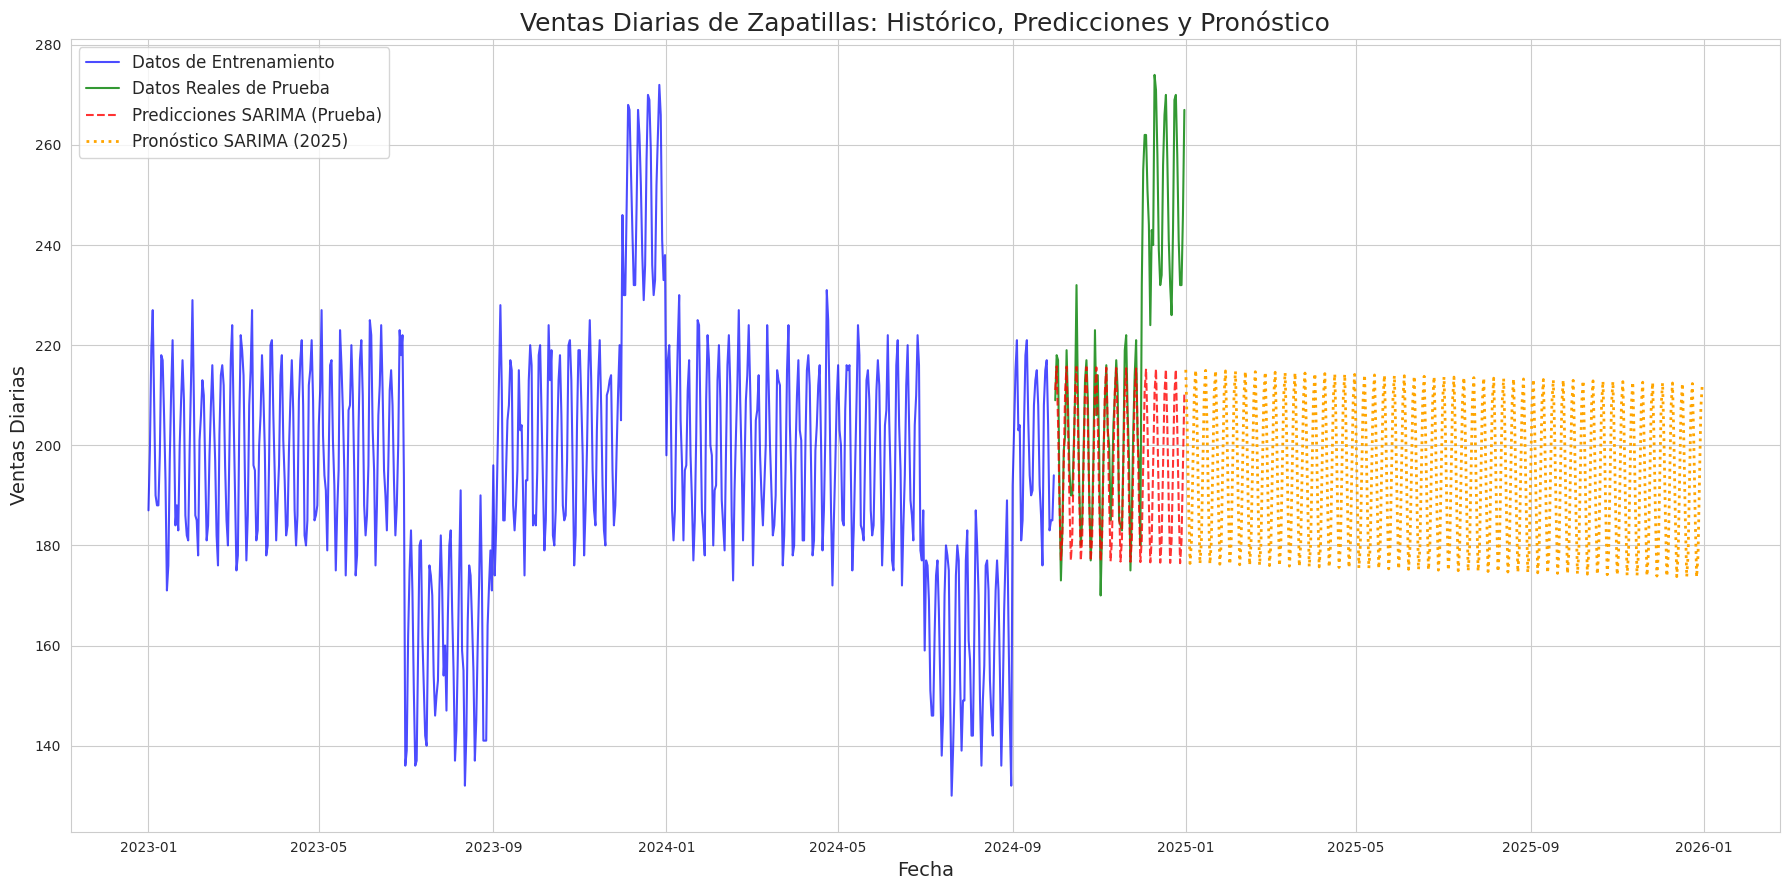

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.figure(figsize=(18, 9))

# Plot historical training data
plt.plot(train_data['daily_sneaker_sales'], label='Datos de Entrenamiento', color='blue', alpha=0.7)

# Plot actual test data
plt.plot(test_data['daily_sneaker_sales'], label='Datos Reales de Prueba', color='green', alpha=0.8)

# Plot SARIMA predictions for the test set
plt.plot(test_data['SARIMA_Predictions'], label='Predicciones SARIMA (Prueba)', color='red', linestyle='--', alpha=0.8)

# Plot SARIMA forecast for the next 12 months (2025)
plt.plot(forecast, label='Pronóstico SARIMA (2025)', color='orange', linestyle=':', linewidth=2)

plt.title('Ventas Diarias de Zapatillas: Histórico, Predicciones y Pronóstico', fontsize=18)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Ventas Diarias', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## Final Task

### Subtask:
Proporcionar un resumen completo del análisis de la serie temporal, la metodología de pronóstico elegida, el pronóstico de ventas a 12 meses generado y las métricas de error calculadas, ofreciendo información sobre el rendimiento del modelo y las expectativas futuras de ventas.


## Summary:

### Q&A

The analysis successfully forecasted sales for the next 12 months, starting from January 1, 2025. The SARIMA model predicts a continuation of the observed sales patterns, including the weekly seasonality and a slight upward trend.

### Data Analysis Key Findings

*   **Data Overview:** The dataset contained 731 daily entries of sneaker sales, with dates ranging from January 1, 2023, to December 31, 2024. The 'date' column was correctly identified as a `datetime64[ns]` type and set as the DataFrame index.
*   **Time Series Characteristics:** Visual inspection and seasonal decomposition revealed a clear **weekly seasonality** (period=7) in daily sneaker sales. A **slightly increasing trend** was also observed throughout the historical data.
*   **Model Selection:** Given the identified trend and strong weekly seasonality, a **SARIMA (Seasonal Autoregressive Integrated Moving Average) model** was selected. This choice was justified by SARIMA's ability to effectively capture both non-seasonal and seasonal components, offering robustness for such patterns. The model was configured with non-seasonal orders (1, 1, 1) and seasonal orders (1, 1, 1, 7).
*   **Data Splitting:** The data was divided into a training set (up to September 30, 2024, 639 entries) and a test set (from October 1, 2024, to December 31, 2024, 92 entries).
*   **Forecast Accuracy:** The SARIMA model's performance on the test set yielded the following error metrics:
    *   Mean Absolute Error (MAE): 21.22
    *   Mean Squared Error (MSE): 991.60
    *   Root Mean Squared Error (RMSE): 31.49
    *   Mean Absolute Percentage Error (MAPE): 8.83\%
    These metrics indicate that the model provides reasonably accurate predictions, with an average absolute percentage error of approximately 8.83\%.
*   **Future Sales Forecast:** The model generated a 12-month sales forecast for 2025 (from January 1, 2025, to December 31, 2025), showing the expected daily sneaker sales incorporating the detected trend and weekly seasonality.

### Insights or Next Steps

*   The model effectively captures the weekly sales cycle and overall trend, making it suitable for operational planning, such as inventory management and staffing, by predicting daily demand fluctuations.
*   To potentially improve forecast accuracy, future work could involve exploring additional exogenous variables (e.g., holidays, promotional events, weather) that might influence sneaker sales, or optimizing SARIMA parameters through a grid search, and comparing its performance with other advanced forecasting models like Prophet or neural network-based models.
